In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.252:52981 Dashboard: http://10.148.0.252:8787/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB


_________
# 1. Read dataset


In [8]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

# read rechunked data
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

# data merge
ds = xr.merge([ds_U,ds_V,ds_W,ds_D,ds_B,grid])

# depth_left
ds = generate_grid_ds(ds, {'Z':'depth'})

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center
Z Axis (not periodic):
  * center   depth (52) --> left
  * left     depth_left (52) --> center


In [14]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

# 2. Vertical gradient

## 2.1 db/dz (i.e., $N^2$)
### note that -1* is necessary to make the sign correct ####

In [8]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
print(db_dz)

<xarray.DataArray 'mul-0f9f6b91d5398acaeb0ae5239b4ff3a9' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


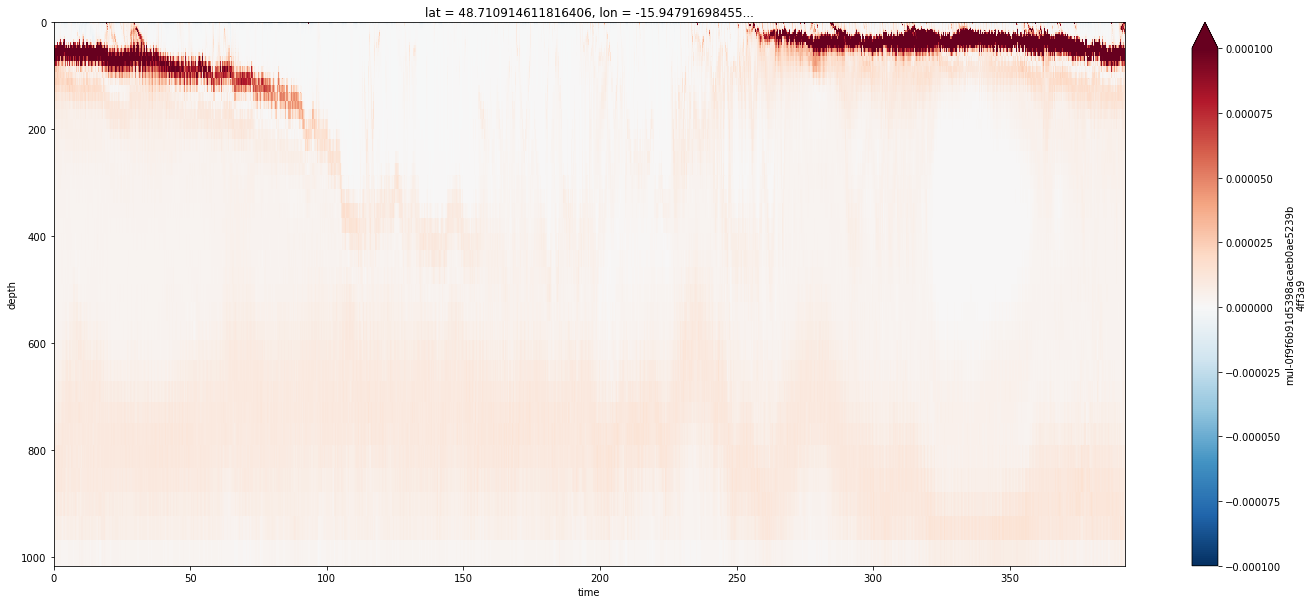

In [9]:
fig = plt.figure(figsize=(24,10))
db_dz.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.0001,vmax=0.0001,cmap='RdBu_r', yincrease=False) # lat=100 & lon=100 is a location near the mooring site

## 2.2 du/dz

In [10]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-839860478b2092d29095fbee9690e90f' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


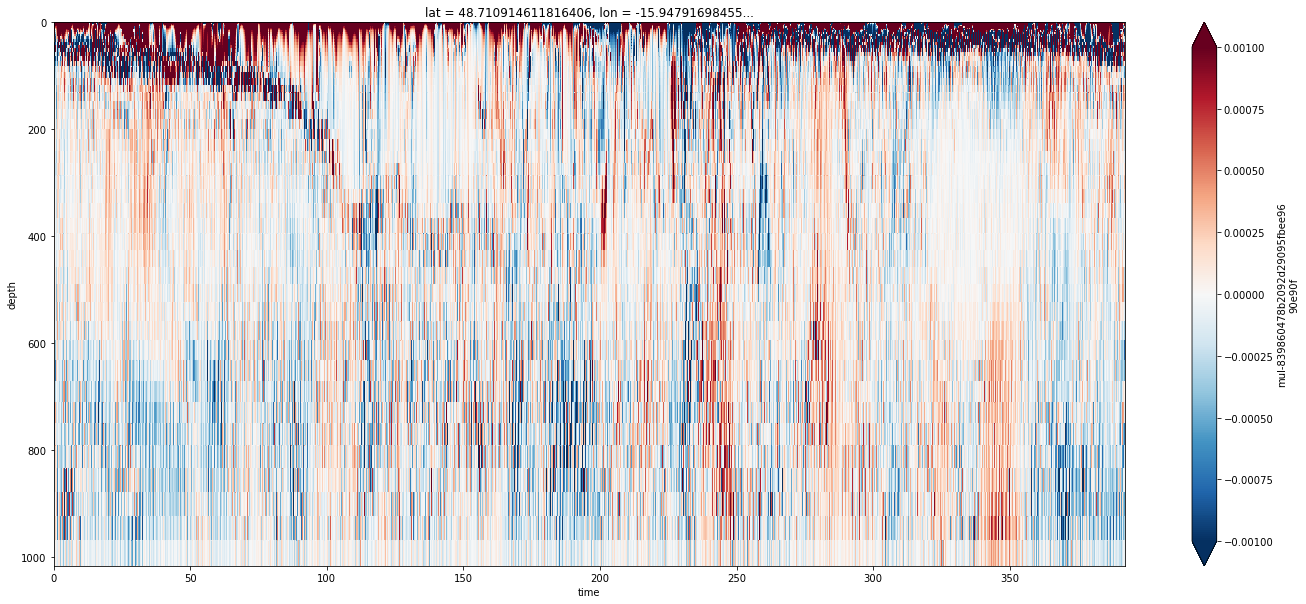

In [11]:
fig = plt.figure(figsize=(24,10))
dU_dz_ij.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.001,vmax=0.001,cmap='RdBu_r', yincrease=False)

# 3. define perturbation (e.g., u', v')

In [9]:
w_mean = ds.W.mean(['lat','lon']) # spatial mean
b_mean = ds.Buoy.mean(['lat','lon'])
u_mean = ds.U.mean(['lat','lon_g'])
v_mean = ds.V.mean(['lat_g','lon'])

In [10]:
w_prime = ds.W - w_mean
b_prime = ds.Buoy - b_mean
u_prime = ds.U - u_mean
v_prime = ds.V - v_mean

In [11]:
u_prime_ij = gridx.interp(u_prime,'X') # interplate into the cell center (i, j or lon, lat)
u_prime_ij

<xarray.DataArray 'mul-b865ad101dad82b3011443c8e0bc2b97' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [12]:
v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

<xarray.DataArray 'mul-3dcb7b35b17ec33d630bc9fde45c29e0' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [15]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-e5023e486fd0f6d11ef63081eb6965a5' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [16]:
dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')
print(dV_dz_ij)

<xarray.DataArray 'mul-a51e01bbeded4cb5b3ea8baffc50c9a5' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


# 4. VSP

## $VSP = -\overline{u_h'w'} \cdot (\partial \overline{u_h}/\partial z)$ with $u_h = (u,v)$

In [17]:
vsp = -1*((w_prime * u_prime_ij).mean(['lat','lon']) * dU_dz_ij.mean(['lat','lon']) + (w_prime * v_prime_ij).mean(['lat','lon']) * dV_dz_ij.mean(['lat','lon']))
vsp

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float64, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

In [18]:
vsp.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[          nan, -3.480584e-09,  3.000753e-10, ...,  5.934344e-11,
         8.841197e-12, -1.198412e-11],
       [          nan, -2.572731e-09,  8.743798e-10, ...,  1.691448e-11,
        -4.626540e-11, -4.614828e-11],
       [          nan,  2.175551e-09,  3.102955e-09, ..., -9.517241e-11,
        -2.026245e-10, -1.383153e-10],
       ...,
       [          nan,  6.064687e-10, -2.149900e-10, ..., -2.572301e-09,
        -1.836207e-09, -7.990804e-10],
       [          nan,  9.397402e-12, -1.352566e-09, ..., -2.062086e-09,
        -1.299769e-09, -5.487724e-10],
       [          nan, -5.178240e-10, -2.148912e-09, ..., -1.254758e-09,
        -5.943510e-10, -2.137739e-10]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

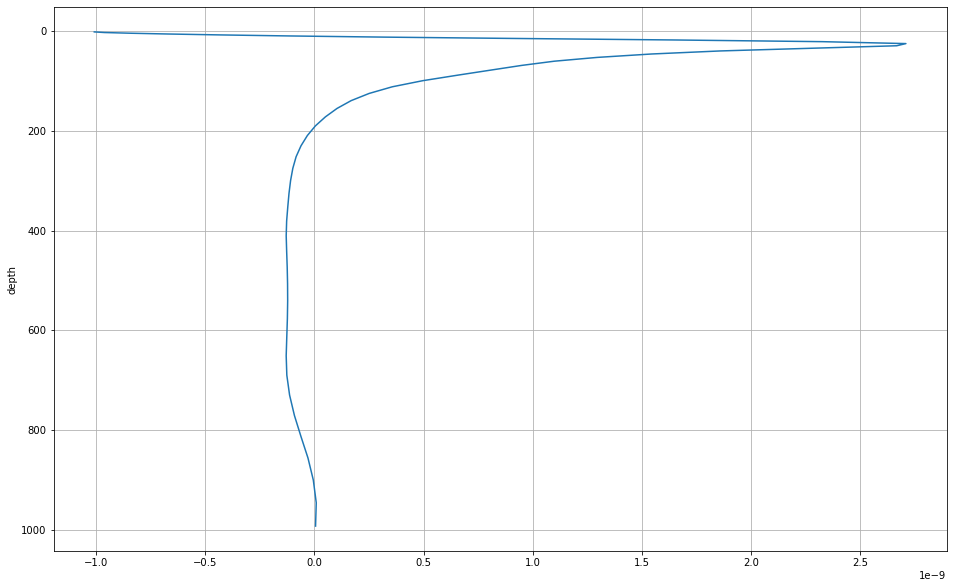

In [20]:
fig, ax = plt.subplots(figsize=(16,10))
vsp.mean('time').plot(y='depth', yincrease=False)
ax.grid()

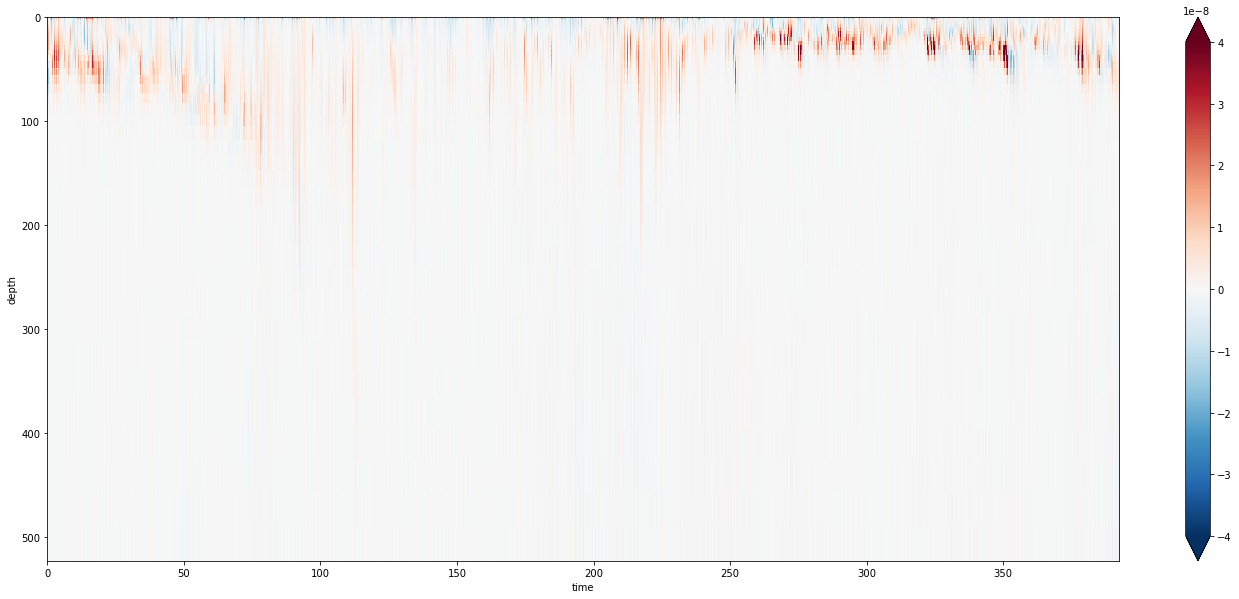

In [40]:
fig = plt.figure(figsize=(24,10))
vsp.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-4e-8,vmax=4e-8,cmap='RdBu_r', yincrease=False)

# 5. w'b'

In [23]:
wb_prime = (w_prime*b_prime).mean(['lat','lon'])
wb_prime

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float32, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

In [24]:
wb_prime.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[ 2.474635e-09,  2.640488e-09,  2.818504e-09, ...,  3.296893e-08,
         2.560053e-08,  1.702176e-08],
       [-2.907991e-09, -2.663564e-09, -2.391995e-09, ...,  1.186818e-08,
         9.636948e-09,  9.009283e-09],
       [-7.772551e-09, -7.404426e-09, -6.983015e-09, ..., -4.150024e-09,
        -1.927034e-09,  4.031266e-09],
       ...,
       [ 1.250806e-09,  3.358193e-09,  5.534526e-09, ...,  5.959661e-08,
         5.750657e-08,  5.834074e-08],
       [ 4.536571e-10,  2.401019e-09,  4.646656e-09, ..., -4.857808e-08,
        -3.294810e-08, -1.165507e-08],
       [-9.984134e-11,  1.424576e-09,  3.215975e-09, ..., -1.492099e-07,
        -1.134001e-07, -7.377513e-08]], dtype=float32)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

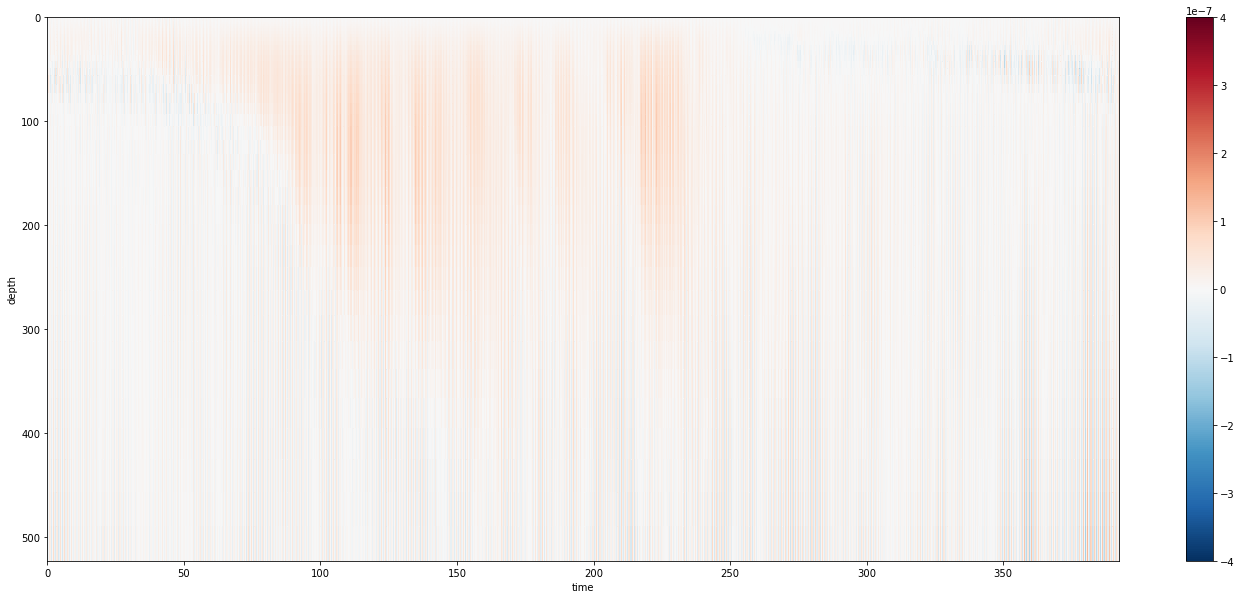

In [26]:
# note that the color scale is one order of magnitude larger than VSP

fig = plt.figure(figsize=(24,10))
wb_prime.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-4e-7,vmax=4e-7,cmap='RdBu_r', yincrease=False)

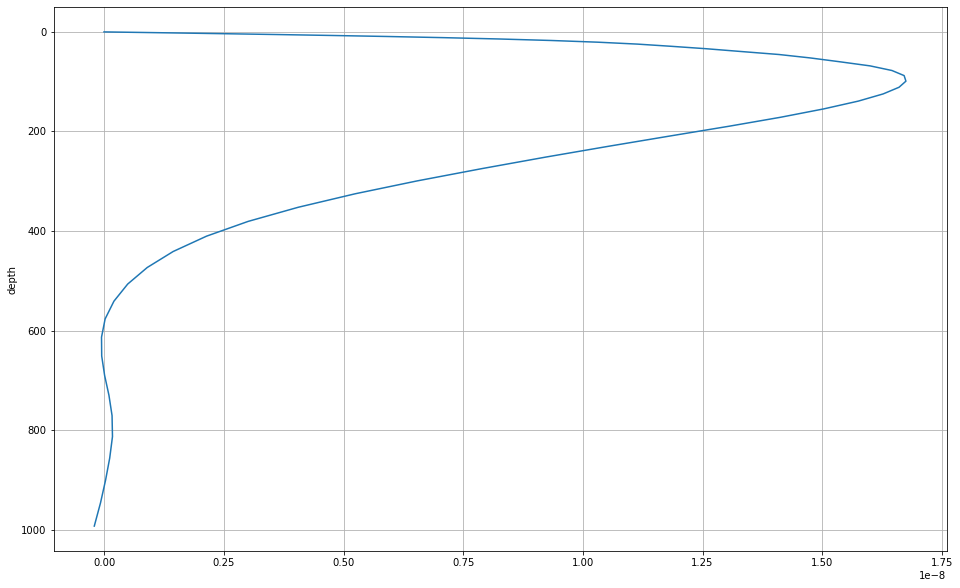

In [27]:
fig, ax = plt.subplots(figsize=(16,10))

wb_prime.mean('time').plot(y='depth', yincrease=False)
ax.grid()

# 6. VSP vs. w'b'

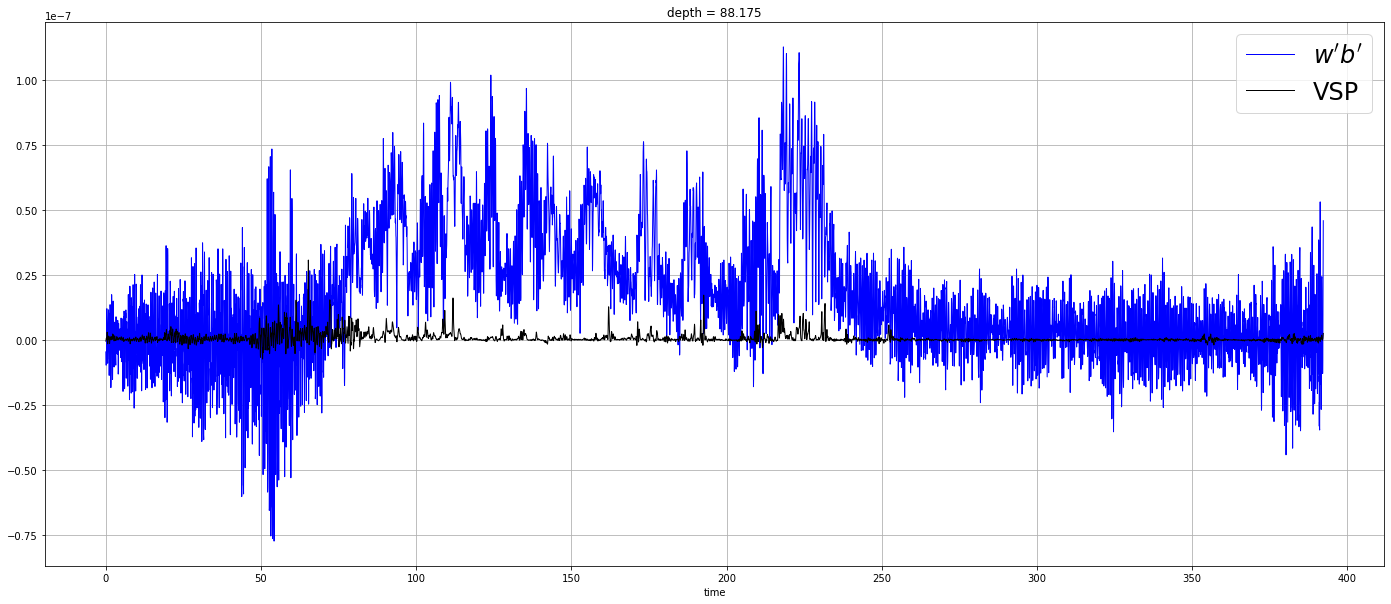

In [54]:
labels = ['VSP', '$w^\prime b^\prime$']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime.isel(depth=20).plot(ax=ax, color='blue', label=labels[1], linewidth=1)
vsp.isel(depth=20).plot(ax=ax, color='black', label=labels[0], linewidth=1)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

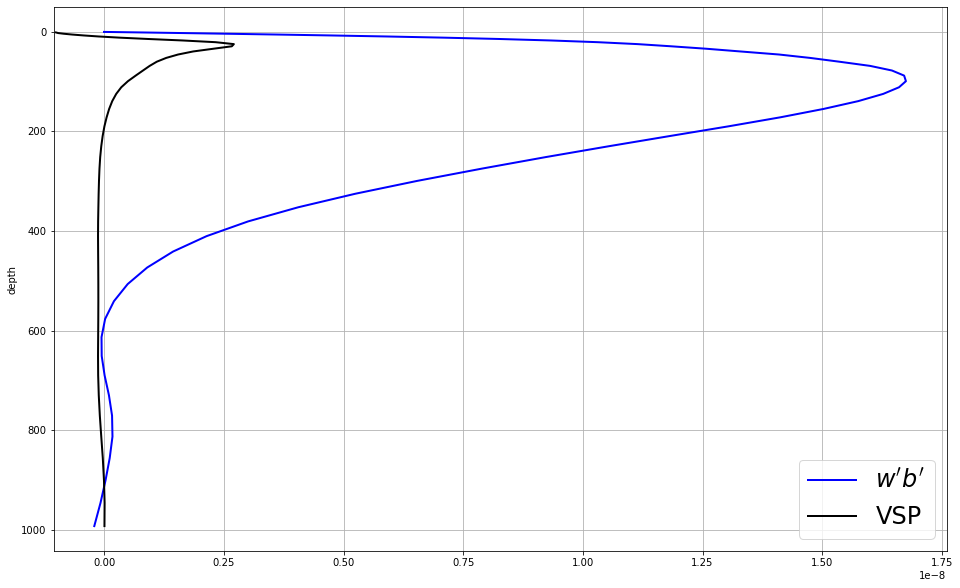

In [55]:
labels = ['VSP', '$w^\prime b^\prime$']

fig, ax = plt.subplots(figsize=(16,10))
wb_prime.mean('time').plot(ax=ax, color='blue', label=labels[1], linewidth=2, y='depth', yincrease=False)
vsp.mean('time').plot(ax=ax, color='black', label=labels[0], linewidth=2, y='depth', yincrease=False)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

In [57]:
cluster.scheduler.close()

<Future finished result=None>